In [67]:
import sys
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

In [69]:
def read_theoretical(path):
    # Read the theoretical starfile
    # We only want (1-indexed): 2 (psi), 3 (phi), 4 (theta), 12 (originX), 13 (originY) 
    # BEWARE skiprows, starfile header lengths may vary
    theoretical = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=21)
    theoretical = theoretical[theoretical.columns[[1, 2, 3, 11, 12]]]
    theoretical.columns = [ 'psi', 'phi', 'theta', 'shiftX', 'shiftY']
    theoretical = theoretical.astype(float)
    return theoretical

In [70]:
def read_experimental(path):
    # Read the experimental parfile
    # BEWARE dropping last two rows.
    experimental = pd.read_csv(path, delim_whitespace=True)
    experimental = experimental[experimental.columns[[1, 3, 2, 4, 5]]]
    experimental.columns = [ 'psi', 'phi', 'theta', 'shiftX', 'shiftY']
    experimental.drop(experimental.tail(2).index,inplace=True)
    experimental = experimental.astype(float)
    return experimental

In [71]:
temet_theoretical = read_theoretical('alignment_data/0.001_temet_simulated.star')
wt_theoretical = read_theoretical('alignment_data/0.001_wt_simulated.star')

temet_experimental = read_experimental('alignment_data/0.001_temet_output.par')
wt_experimental = read_experimental('alignment_data/0.001_wt_output.par')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [72]:
temet_errors = temet_theoretical.sub(temet_experimental)
wt_errors = wt_theoretical.sub(wt_experimental)

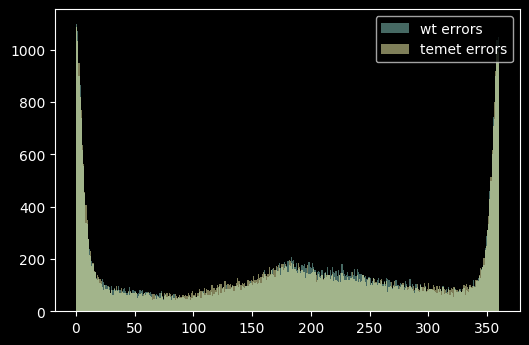

In [108]:
# fig = plt.figure(figsize=(12, 5))
# errors.phi.hist(bins=360
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist((wt_errors.theta % 360), bins=360, alpha=0.5, label='wt errors');
ax.hist((temet_errors.theta % 360), bins=360, alpha=0.5, label='temet errors');
plt.legend(loc='upper right')

In [120]:
sum(abs(temet_errors.psi) > 50)
# sum(abs(wt_errors.psi) > 50)

28920

In [99]:
sum(wt_errors.shiftY)/len(wt_errors.shiftY)

-0.015910599999999997